# Plot recovered versus un-recovered equivalent pathway mappings from ORA results

In [1]:
import json
import os
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools as itt

from bio2bel_kegg import Manager as KeggManager
from bio2bel_reactome import Manager as ReactomeManager
from bio2bel_wikipathways import Manager as WikipathwaysManager

from pathway_forte.constants import *
from pathway_forte.pathway_enrichment.functional_class import *

In [2]:
# Initiate Bio2BEL manager to map pathway identifiers to names
kegg_manager = KeggManager()
reactome_manager = ReactomeManager()
wikipathways_manager = WikipathwaysManager()

In [3]:
brca_dataset = 'brca'
kirc_dataset = 'kirc'
lihc_dataset = 'lihc'
prad_dataset = 'prad'

In [5]:
def get_spia_results(dataset, p_value=None):
    """Get SPIA results for KEGG, Reactome and WikiPathways for a dataset from JSON file. 
    """
    kegg_path = os.path.join(PROJECT_SPIA, dataset, f'{dataset}_kegg_spia.csv')
    reactome_path = os.path.join(PROJECT_SPIA, dataset, f'{dataset}_reactome_spia.csv')
    wikipathways_path = os.path.join(PROJECT_SPIA, dataset, f'{dataset}_wikipathways_spia.csv')

    kegg_df_total = pd.read_csv(kegg_path, sep=',')
    reactome_df_total = pd.read_csv(reactome_path, sep=',')
    wp_df_total = pd.read_csv(wikipathways_path, sep=',')
    
    kegg_df = pd.DataFrame()
    reactome_df = pd.DataFrame()
    wp_df = pd.DataFrame()
    
    kegg_df['pathway_id'] = [('hsa0' + str(_id)) for _id in kegg_df_total['ID']]
    reactome_df['pathway_id'] = [('R-HSA-' + str(_id)) for _id in reactome_df_total['ID']]
    wp_df['pathway_id'] = [_id for _id in wp_df_total['ID']]

    kegg_df['status'] = [i for i in kegg_df_total['Status']]
    reactome_df['status'] = [i for i in reactome_df_total['Status']]
    wp_df['status'] = [i for i in wp_df_total['Status']]
    
    # get Bonferroni adjusted global p-value
    kegg_df['pGFWER'] = [i for i in kegg_df_total['pGFWER']]
    reactome_df['pGFWER'] = [i for i in reactome_df_total['pGFWER']]
    wp_df['pGFWER'] = [i for i in wp_df_total['pGFWER']]
        
    # Filter dataFrame to include only those pathways with an adjusted p-value less than X
    if p_value is not None:
        kegg_df = kegg_df.loc[kegg_df['pGFWER'] < p_value]
        reactome_df = reactome_df.loc[reactome_df['pGFWER'] < p_value]
        wp_df = wp_df.loc[wp_df['pGFWER'] < p_value]

    # sort dataFrame by Bonferroni adjusted global p-value
    kegg_df.sort_values('pGFWER', inplace=True)
    reactome_df.sort_values('pGFWER', inplace=True)
    wp_df.sort_values('pGFWER', inplace=True)

    return kegg_df, reactome_df, wp_df


In [6]:
def get_pathway_names(
        database, 
        pathway_df,
        kegg_manager: Optional[bio2bel_kegg.Manager] = None,
        reactome_manager: Optional[bio2bel_reactome.Manager] = None,
        wikipathways_manager: Optional[bio2bel_wikipathways.Manager] = None
):  
    
    if database == KEGG:
        pathway_df['pathway_name'] = [
            kegg_manager.get_pathway_by_id('path:' + pathway_id)
            for pathway_id in list(pathway_df['pathway_id'])
        ]
        return pathway_df

    elif database == REACTOME:
        pathway_df['pathway_name'] = [
            reactome_manager.get_pathway_by_id(pathway_id)
            for pathway_id in list(pathway_df['pathway_id'])
        ]
        return pathway_df
    
    elif database == WIKIPATHWAYS:
        pathway_df['pathway_name'] = [
            wikipathways_manager.get_pathway_by_id(pathway_id)
            for pathway_id in list(pathway_df['pathway_id'])
        ]
        return pathway_df


In [7]:
brca_kegg_df, brca_reactome_df, brca_wp_df = get_spia_results('brca',0.05)
kirc_kegg_df, kirc_reactome_df, kirc_wp_df = get_spia_results('kirc',0.05)
lihc_kegg_df, lihc_reactome_df, lihc_wp_df = get_spia_results('lihc',0.05)
prad_kegg_df, prad_reactome_df, prad_wp_df = get_spia_results('prad',0.05)

In [8]:
brca_kegg_df = get_pathway_names('kegg',brca_kegg_df,kegg_manager=kegg_manager)
kirc_kegg_df = get_pathway_names('kegg',kirc_kegg_df,kegg_manager=kegg_manager)
lihc_kegg_df = get_pathway_names('kegg',lihc_kegg_df,kegg_manager=kegg_manager)
prad_kegg_df = get_pathway_names('kegg',prad_kegg_df,kegg_manager=kegg_manager)

In [9]:
brca_reactome_df = get_pathway_names('reactome',brca_reactome_df,reactome_manager=reactome_manager)
kirc_reactome_df = get_pathway_names('reactome',kirc_reactome_df,reactome_manager=reactome_manager)
lihc_reactome_df = get_pathway_names('reactome',lihc_reactome_df,reactome_manager=reactome_manager)
prad_reactome_df = get_pathway_names('reactome',prad_reactome_df,reactome_manager=reactome_manager)

In [10]:
brca_wp_df = get_pathway_names('wikipathways',brca_wp_df,wikipathways_manager=wikipathways_manager)
kirc_wp_df = get_pathway_names('wikipathways',kirc_wp_df,wikipathways_manager=wikipathways_manager)
lihc_wp_df = get_pathway_names('wikipathways',lihc_wp_df,wikipathways_manager=wikipathways_manager)
prad_wp_df = get_pathway_names('wikipathways',prad_wp_df,wikipathways_manager=wikipathways_manager)

In [11]:
brca_actual_dict, brca_expected_dict = get_pairwise_mapping_numbers(
    brca_kegg_df, 
    brca_reactome_df, 
    brca_wp_df, 
)
kirc_actual_dict, kirc_expected_dict = get_pairwise_mapping_numbers(
    kirc_kegg_df, 
    kirc_reactome_df, 
    kirc_wp_df, 
)
lihc_actual_dict, lihc_expected_dict = get_pairwise_mapping_numbers(
    lihc_kegg_df, 
    lihc_reactome_df, 
    lihc_wp_df, 
)
prad_actual_dict, prad_expected_dict = get_pairwise_mapping_numbers(
    prad_kegg_df, 
    prad_reactome_df, 
    prad_wp_df, 
)

Plot how many pairwise pathways with mappings exist versus how many are expected

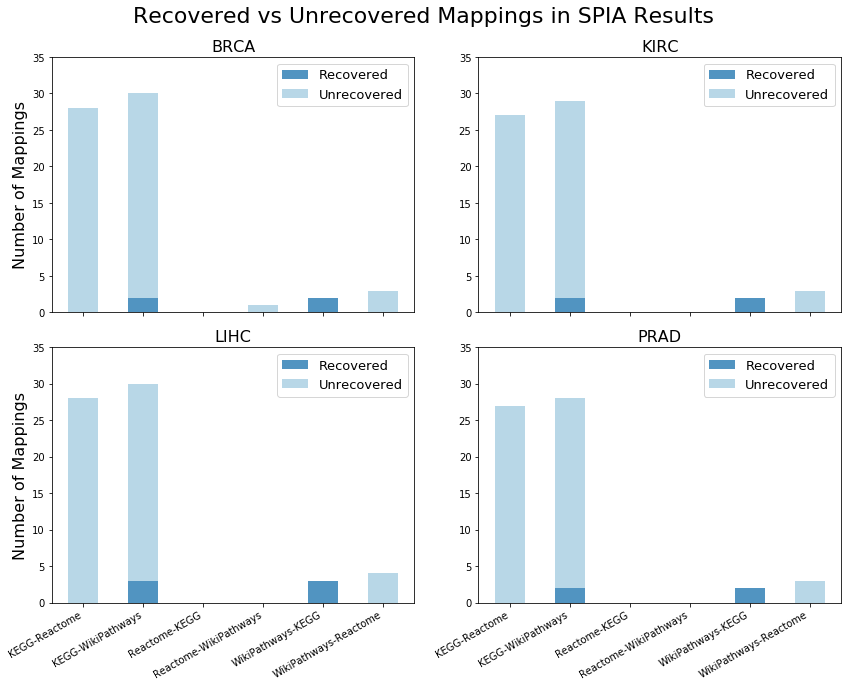

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
fig.suptitle('Recovered vs Unrecovered Mappings in SPIA Results', fontsize=22)

N = 6
index = np.arange(N)
bar_width = 0.5
opacity = 0.8

pairings = ('KEGG-Reactome', 
 'KEGG-WikiPathways', 
 'Reactome-KEGG', 
 'Reactome-WikiPathways',
 'WikiPathways-KEGG', 
 'WikiPathways-Reactome',
)
label_font = {'size': 16}

plt.subplot(2, 2, 1)
actual_vals = list(brca_actual_dict.values())
expected_vals = list(brca_expected_dict.values())
difference = [x - y for x, y in zip(expected_vals, actual_vals)]

p1 = plt.bar(index, actual_vals, bar_width,alpha=opacity, color='#2679b2',label='Recovered')
p2 = plt.bar(index, difference, bar_width, bottom=actual_vals, alpha=opacity, color='#a7cee2',label='Unrecovered')

plt.title('BRCA', fontsize=16)
plt.ylabel('Number of Mappings', fontdict=label_font)
plt.xticks(index, pairings)
plt.ylim(0,35)
plt.legend(prop={'size':13},loc=1)


plt.subplot(2, 2, 2)
actual_vals = list(kirc_actual_dict.values())
expected_vals = list(kirc_expected_dict.values())
difference = [x - y for x, y in zip(expected_vals, actual_vals)]

p1 = plt.bar(index, actual_vals, bar_width,alpha=opacity, color='#2679b2',label='Recovered')
p2 = plt.bar(index, difference, bar_width, bottom=actual_vals, alpha=opacity, color='#a7cee2',label='Unrecovered')

plt.title('KIRC', fontsize=16)
plt.xticks(index, pairings)
plt.ylim(0,35)
plt.legend(prop={'size':13},loc=1)

plt.subplot(2, 2, 3)
actual_vals = list(lihc_actual_dict.values())
expected_vals = list(lihc_expected_dict.values())
difference = [x - y for x, y in zip(expected_vals, actual_vals)]

p1 = plt.bar(index, actual_vals, bar_width,alpha=opacity, color='#2679b2',label='Recovered')
p2 = plt.bar(index, difference, bar_width, bottom=actual_vals, alpha=opacity, color='#a7cee2',label='Unrecovered')

plt.title('LIHC', fontsize=16)
plt.ylabel('Number of Mappings', fontdict=label_font)
plt.xticks(index, pairings)
plt.ylim(0,35)
plt.legend(prop={'size':13},loc=1)

plt.subplot(2, 2, 4)
actual_vals = list(prad_actual_dict.values())
expected_vals = list(prad_expected_dict.values())
difference = [x - y for x, y in zip(expected_vals, actual_vals)]

p1 = plt.bar(index, actual_vals, bar_width,alpha=opacity, color='#2679b2',label='Recovered')
p2 = plt.bar(index, difference, bar_width, bottom=actual_vals, alpha=opacity, color='#a7cee2',label='Unrecovered')

plt.title('PRAD', fontsize=16)
plt.ylim(0,35)
plt.xticks(index, pairings)
plt.legend(prop={'size':13},loc=1)

fig.autofmt_xdate()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('pairwise_mappings.png',dpi=250)
plt.show()